<a href="https://colab.research.google.com/github/alexhosp/startup-viability-analysis/blob/main/customer-segmentation/notebooks/01_data_collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection for Customer Segmentation
## Introduction
This notebook focuses on collecting data to identify and segment potential customers for a proposed AI-driven gardening robot startup. We will use multiple APIs to gather data from sources such as Google Trends, Twitter, Reddit, Google Custom Search, Kaggle, Google Dataset Search, and UCI Machine Learning Repository. All raw data will be stored in Google Cloud Storage (GCS).
## Steps
1. [Setup and GCS Configuration](#setup-gcs-configuration)
2. [Definition of Initial Keywords](#initial-keywords-definition)
3. Data Collection
  1. [Google Trends](#google-trends)
    1. [API Authentication and Configuration](#api-authentication-configuration)
    2. [Defining Data Collection Functions](#defining-data-collection-functions)
    3. [Collect Relevant Data](#collect-relevant-data)
    4. [Clean and Transform Data](#clean-and-transform-data)
    5. [Explore the Data](#explore-the-data)
    6. [Evaluate and Select Relevant Data](#evaluate-and-select-relevant-data)
    7. [Store Data in GCS](#store-data-in-gcs)

*Decide on how to proceed here, Twitter API might not be accessible*

* Twitter API
* Reddit API
* Google Custom Search API
5. Executing Data Collection Functions
6. Storing Data in GCS
7. Semantic Expansion of Keywords
8. Definition of Additional Keywords
9. Defining Data Collection Functions for Structured Data
* Kaggle API
* Google Dataset Search API
* UCI Machine Learning Repository API
10. Executing Data Collection for Additional Data
11. Iterative Data Collection


<a name="setup-gcs-configuration"></a>
## Setup and GCS Configuration
* Install necessary libraries
* Authenticate and access GCS
* Set up a GCS bucket for storage

In [7]:
# Install and import necessary libraries
!pip install google-cloud-storage
from google.cloud import storage
import pandas as pd
from google.colab import auth

In [8]:
# Authenticate with GCP
auth.authenticate_user()

In [48]:
# Set up GCS client
project_id = 'idyllic-gear-422709-g4'
storage_client = storage.Client(project=project_id)

# Create a new bucket to store all data in
bucket_name = 'startup-viability-analysis'
bucket = storage_client.bucket(bucket_name)
bucket.storage_class = 'STANDARD'
bucket = storage_client.create_bucket(bucket, location='us-east1')

print(
        "Created bucket {} in {} with storage class {}".format(
            bucket.name, bucket.location, bucket.storage_class
        )
    )

Created bucket startup-viability-analysis in US-EAST1 with storage class STANDARD


In [53]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a name="initial-keywords-definition"></a>
# Definition of Initial Keywords
The initial keywords are chosen to gather data on the interest of features of a proposed prototype and the relevance of problems and needs the prototype seeks to address.

## Read in the keyword lists from GitHub

In [10]:
# Import necessary libraries
!pip install requests
import requests

In [11]:
# Define file paths
base_url = 'https://raw.githubusercontent.com/alexhosp/startup-viability-analysis/main/customer-segmentation/data/raw/'
files = ['features.txt', 'problems.txt', 'needs.txt']

# Retrieve text files and convert them to Python lists
features = requests.get(base_url + files[0]).text.splitlines()
problems = requests.get(base_url + files[1]).text.splitlines()
needs = requests.get(base_url + files[2]).text.splitlines()
len(features)

55

<a name='google-trends'></a>
# Google Trends
Collect data from Google Trends based on define keywords

<a name='api-authentication-configuration'></a>
# Pytrends API Authentication & Configuration

In [12]:
# Import necessary libraries
!pip install pytrends
from pytrends.request import TrendReq
!pip install urllib3==1.25.11

In [13]:
# Initialize Pytrends
pytrends = TrendReq(hl='en-US', tz=360, timeout=(5,20), retries=2)

In [14]:
# Import datetime
from datetime import datetime, timedelta

In [15]:
# Define timeframe
end_date = datetime.now()
start_date = end_date - timedelta(days=3*365)
end_date
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')
timeframe = f'{start_date_str} {end_date_str}'
timeframe

'2021-06-29 2024-06-28'

<a name='defining-data-collection-functions'></a>
# Defining Data Collection Functions
* Define functions to collect data from Google Trends
* Fetch interest over time, interest by region, search trends in regions of most interest, related queries, related topics, related categories and search suggestions for features, problems and needs


## Collect interest over time
* Find out about interest in proposed features
* Find out about interest in problems (relevance)
* Find out about interest in needs (relevance)

In [16]:
# Split features list into 5 keyword batches
batch_size = 5
features_chunks = [features[i:i+batch_size] for i in range(0, len(features), batch_size)]
len(features_chunks)

11

In [73]:
# Split problems list into 5 keyword batches
batch_size = 5
problems_chunks = [problems[i:i+batch_size] for i in range(0, len(problems), batch_size)]
len(problems_chunks)
problems_chunks[4]

['Lack of integrated ecosystem management in farming systems',
 'Focus on single crops in agriculture innovation',
 'Underutilization of natural biodiversity',
 'Unstable farming systems through conventional practices',
 'Lack of data on the natural environment']

In [74]:
# Define a function to fetch interest over time for a list of keyword chunks
def fetch_interest_over_time(pytrends, chunks, timeframe='today 5-y'):
    """
    Fetch interest over time data from Google Trends for given chunks of keywords.

    Args:
    pytrends (TrendReq): An authenticated Google Trends API client.
    features_chunks (list of list of str): A list where each element is a list of keywords.
    timeframe (str): The timeframe for the Google Trends data (default: 'today 5-y').

    Returns:
    list of pd.DataFrame: A list of DataFrames with the interest over time data for each chunk of keywords.
    """
    dataframes = []

    for i, chunk in enumerate(chunks):
        print(f"Processing chunk {i+1}/{len(chunks)}: {chunk}")
        pytrends.build_payload(kw_list=chunk, timeframe=timeframe)
        df = pytrends.interest_over_time()
        df = df.iloc[:-1]  # Remove the last row (most recent, partial week)
        if 'isPartial' in df.columns:
            df = df.drop(columns=['isPartial'])
        print(f"DataFrame shape: {df.shape}")
        dataframes.append(df)
        print(f"Processed chunk {i+1}/{len(chunks)}")

    print(f"Number of dataframes: {len(dataframes)}")
    return dataframes


<a name='collect-relevant-data'></a>
# Collect relevant data
* Use data collection functions to collect data from Google Trends

## Collect interest over time in proposed features

In [75]:
# Get interest over time for for features as list of dataframes
features_interest_dataframes = fetch_interest_over_time(pytrends=pytrends, chunks=features_chunks, timeframe=timeframe)

Processing chunk 1/11: ['Computer vision for environmental understanding', 'Real-time monitoring sensors', 'Raspberry Pi processing for community engagement', 'Hexapod mobility and agility', 'Portable agricultural technology']
DataFrame shape: (156, 5)
Processed chunk 1/11
Processing chunk 2/11: ['Indoor and outdoor ecosystem management', 'Environmental data to mobile app', 'Robot control and monitoring app', 'Plant classification and beneficial relationships', 'Self-sufficient ecosystem design']
DataFrame shape: (156, 5)
Processed chunk 2/11
Processing chunk 3/11: ['Ecosystem health classification', 'Educational information on plants and environments', 'Modular plug-and-play design for sensors and tools', 'Real-time environment monitoring', 'Plant detection']
DataFrame shape: (156, 5)
Processed chunk 3/11
Processing chunk 4/11: ['Plant health classification', 'Plant relationship identification in ecosystems', 'Beneficial ecosystem modeling', 'Ecosystem risk detection', 'Accessible for

In [23]:
len(features_interest_dataframes)

11

In [24]:
# Combine all dataframes into a single dataframe
features_interest_over_time_df = pd.concat(features_interest_dataframes, axis=1)
features_interest_over_time_df.tail()

,Computer vision for environmental understanding,Real-time monitoring sensors,Raspberry Pi processing for community engagement,Hexapod mobility and agility,Portable agricultural technology,Indoor and outdoor ecosystem management,Environmental data to mobile app,Robot control and monitoring app,Plant classification and beneficial relationships,Self-sufficient ecosystem design,...,Adaptive algorithms for environmental conditions,Support for local biodiversity,Resource-efficient plant growth with minimal external inputs,Energy-efficient with solar charging for outdoor use,Remote access and control,AI-driven recommendations for food system health,AI-driven recommendations,Food system health,Plant identification,Automated gardening
date,,,,,,,,,,,,,,,,,,,,,
2024-05-19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,65,0,0,16,65,0
2024-05-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,52,0,0,14,61,0
2024-06-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,99,0,0,17,61,0
2024-06-09,0,8,0,0,0,0,0,0,0,0,...,0,0,0,0,48,0,0,17,59,0
2024-06-16,0,33,0,0,0,0,0,0,0,0,...,0,4,0,0,54,0,1,11,55,0


In [25]:
features_interest_over_time_df.shape[0]

156

## Collect interest over time in problems solved by the prototype (relevance of the problems)

In [77]:
# Get interest over time for for features as list of dataframes
problems_interest_dataframes = fetch_interest_over_time(pytrends=pytrends, chunks=problems_chunks, timeframe=timeframe)

Processing chunk 1/5: ['Lack of portability in automated farming', 'No biological understanding in gardening automation', 'Monoculture in agriculture', 'Long-distance food transport', 'Disconnect between people and food sources']
DataFrame shape: (156, 5)
Processed chunk 1/5
Processing chunk 2/5: ['Use of preservatives and pesticides in produce', 'Separation of food production from natural ecosystems', 'Lack of ecosystem integration in automated food production', 'Lack of natural environment in agricultural innovation', 'Inaccessibility of personal gardening automation']
DataFrame shape: (156, 5)
Processed chunk 2/5
Processing chunk 3/5: ['Limited educational resources in gardening tech', 'Lack of versatile agricultural robots for indoor and outdoor use', 'Inefficient energy and resource use in automated farming solutions', 'Inability to create self-sufficient ecosystems with current tech', 'Lack of understanding of the natural world']
DataFrame shape: (156, 5)
Processed chunk 3/5
Proc

In [80]:
# Combine all dataframes into a single dataframe
problems_interest_over_time = pd.concat(problems_interest_dataframes, axis=1)
problems_interest_over_time.tail()

,Lack of portability in automated farming,No biological understanding in gardening automation,Monoculture in agriculture,Long-distance food transport,Disconnect between people and food sources,Use of preservatives and pesticides in produce,Separation of food production from natural ecosystems,Lack of ecosystem integration in automated food production,Lack of natural environment in agricultural innovation,Inaccessibility of personal gardening automation,...,Lack of agricultural AI for natural ecosystems,High costs of automated farming solutions,Limited adaptability of automated gardening systems,Complex setup of automated gardening solutions,Environmental impact of commercial farming solutions,Lack of integrated ecosystem management in farming systems,Focus on single crops in agriculture innovation,Underutilization of natural biodiversity,Unstable farming systems through conventional practices,Lack of data on the natural environment
date,,,,,,,,,,,,,,,,,,,,,
2024-05-19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-05-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-06-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-06-09,0,0,5,100,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-06-16,0,0,15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a name='clean-and-transform-data'></a>
# Clean and Transform Data
* Clean and transform all data collected for analysis
* Remove duplicate and irrelevant entries
* Sort data and create new relevant features


## Clean and transform interest over time in proposed features data

In [41]:
highest_interest_sorted = features_interest_over_time_df.sum().sort_values(ascending=False)
highest_interest_sorted.tail(10)

Focus on sustainability and natural growing methods       0
Modular plug-and-play design for sensors and tools        0
Beneficial ecosystem modeling                             0
Organic gardening helper                                  0
Versatile for various agricultural needs                  0
Accessible for small-scale farmers and consumers          0
Scalable farming system through interconnecting robots    0
Real-time response to environmental changes               0
Resource optimization and waste minimization              0
Self-sufficient ecosystem design                          0
dtype: int64

### Determine features with most interest
* Determine the features with most interest and features
* Create two tables, one with features sorted by relevance and one with features with zero relevance

In [43]:
# Calculate the sum of values in each column and sort in descending order
sorted_by_interest = features_interest_over_time_df.sum().sort_values(ascending=False)

# Determine keywords with no interest
zero_interest_keywords = sorted_by_interest[sorted_by_interest == 0].index.tolist()
zero_interest_keywords

#Sort remaining keywords by interest
sorted_by_interest = sorted_by_interest[sorted_by_interest != 0]
sorted_by_interest

# Format keywords in a table
features_by_interest = pd.DataFrame(data=sorted_by_interest, columns=['interest'])
features_by_interest.tail()

,interest
Adaptable to indoor and outdoor environments,11
Automated gardening,2
Remote gardening,1
Real-time monitoring and data collection,1
AI-driven recommendations,1


Interest is measured as the sum of monthly Google Trends Interest values (from 0 to 100) over a period of three years.

### Determine weekly average interest per keyword
* Data has been collected over a period of 3 years or 156 days. Google determines the pooularity of a keyword per week on a scale from 1 - 100.
* Determine the average weekly interest to get values in a range from 1 to 100 for all features with more than zero interest

In [44]:
features_by_interest['weekly_average_interest'] = round(features_by_interest['interest'] / 156.42, 3)
features_by_interest.tail()

,interest,weekly_average_interest
Adaptable to indoor and outdoor environments,11,0.070
Automated gardening,2,0.013
Remote gardening,1,0.006
Real-time monitoring and data collection,1,0.006
AI-driven recommendations,1,0.006


### Determine keywords with no interest
* Either these keywords need to be improved, or the features are of minimal value to consumers
* Store features with zero interest in a separate dataframe for further analysis

In [32]:
zero_interest_features = pd.DataFrame(zero_interest_keywords, columns=['zero_interest_keywords'])
zero_interest_features.head()

,zero_interest_keywords
0,Affordable for end users
1,Raspberry Pi processing for community engagement
2,Hexapod mobility and agility
3,AI-driven recommendations for food system health
4,Portable agricultural technology


Some of these keywords are too complex and need to restated.

## Clean and transform relevance of problems data

In [85]:
# Sort problems by relevance
relevance_problems_interest_over_time = problems_interest_over_time.sum().sort_values(ascending=False)

# Remove problems with zero relevance and create a new series
zero_relevance_problems = relevance_problems_interest_over_time[relevance_problems_interest_over_time == 0]
zero_relevance_problems.head()

# Remove zero relevance problems from problems by relevance and return a new series
problems_by_relevance = relevance_problems_interest_over_time[relevance_problems_interest_over_time != 0]
problems_by_relevance.head()

Monoculture in agriculture                              2068
Environmental impact of commercial farming solutions     167
Long-distance food transport                             155
Limited adaptability of automated gardening systems      155
High costs of automated farming solutions                100
dtype: int64

<a name='explore-the-data'></a>
# Explore the Data
* Conduct initial exploration to understand the data collected
* Generate summary statistics and visualizations  
* Identify patterns in data

## Explore intrest over time in proposed features

### Visualize how feature interest changes over time

In [33]:
# Install necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt


In [37]:
# Create dataframe with monthly time intervals
features_interest_over_time_monthly = features_interest_over_time_df.resample('M').sum()
features_interest_over_time_monthly.index = features_interest_over_time_monthly.index.strftime('%B %Y')
features_interest_over_time_monthly.head()

,Computer vision for environmental understanding,Real-time monitoring sensors,Raspberry Pi processing for community engagement,Hexapod mobility and agility,Portable agricultural technology,Indoor and outdoor ecosystem management,Environmental data to mobile app,Robot control and monitoring app,Plant classification and beneficial relationships,Self-sufficient ecosystem design,...,Adaptive algorithms for environmental conditions,Support for local biodiversity,Resource-efficient plant growth with minimal external inputs,Energy-efficient with solar charging for outdoor use,Remote access and control,AI-driven recommendations for food system health,AI-driven recommendations,Food system health,Plant identification,Automated gardening
date,,,,,,,,,,,,,,,,,,,,,
June 2021,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7,83,0
July 2021,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,150,0,0,28,340,0
August 2021,0,0,0,0,0,0,0,0,0,0,...,28,39,0,0,70,0,0,42,332,0
September 2021,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,52,241,0
October 2021,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,74,0,0,64,232,0


In [35]:
# Include only column with more than 0 total interest
non_zero_columns = features_interest_over_time_monthly.sum()[features_interest_over_time_monthly.sum() > 0].index
features_interest_over_time_monthly = features_interest_over_time_monthly[non_zero_columns]

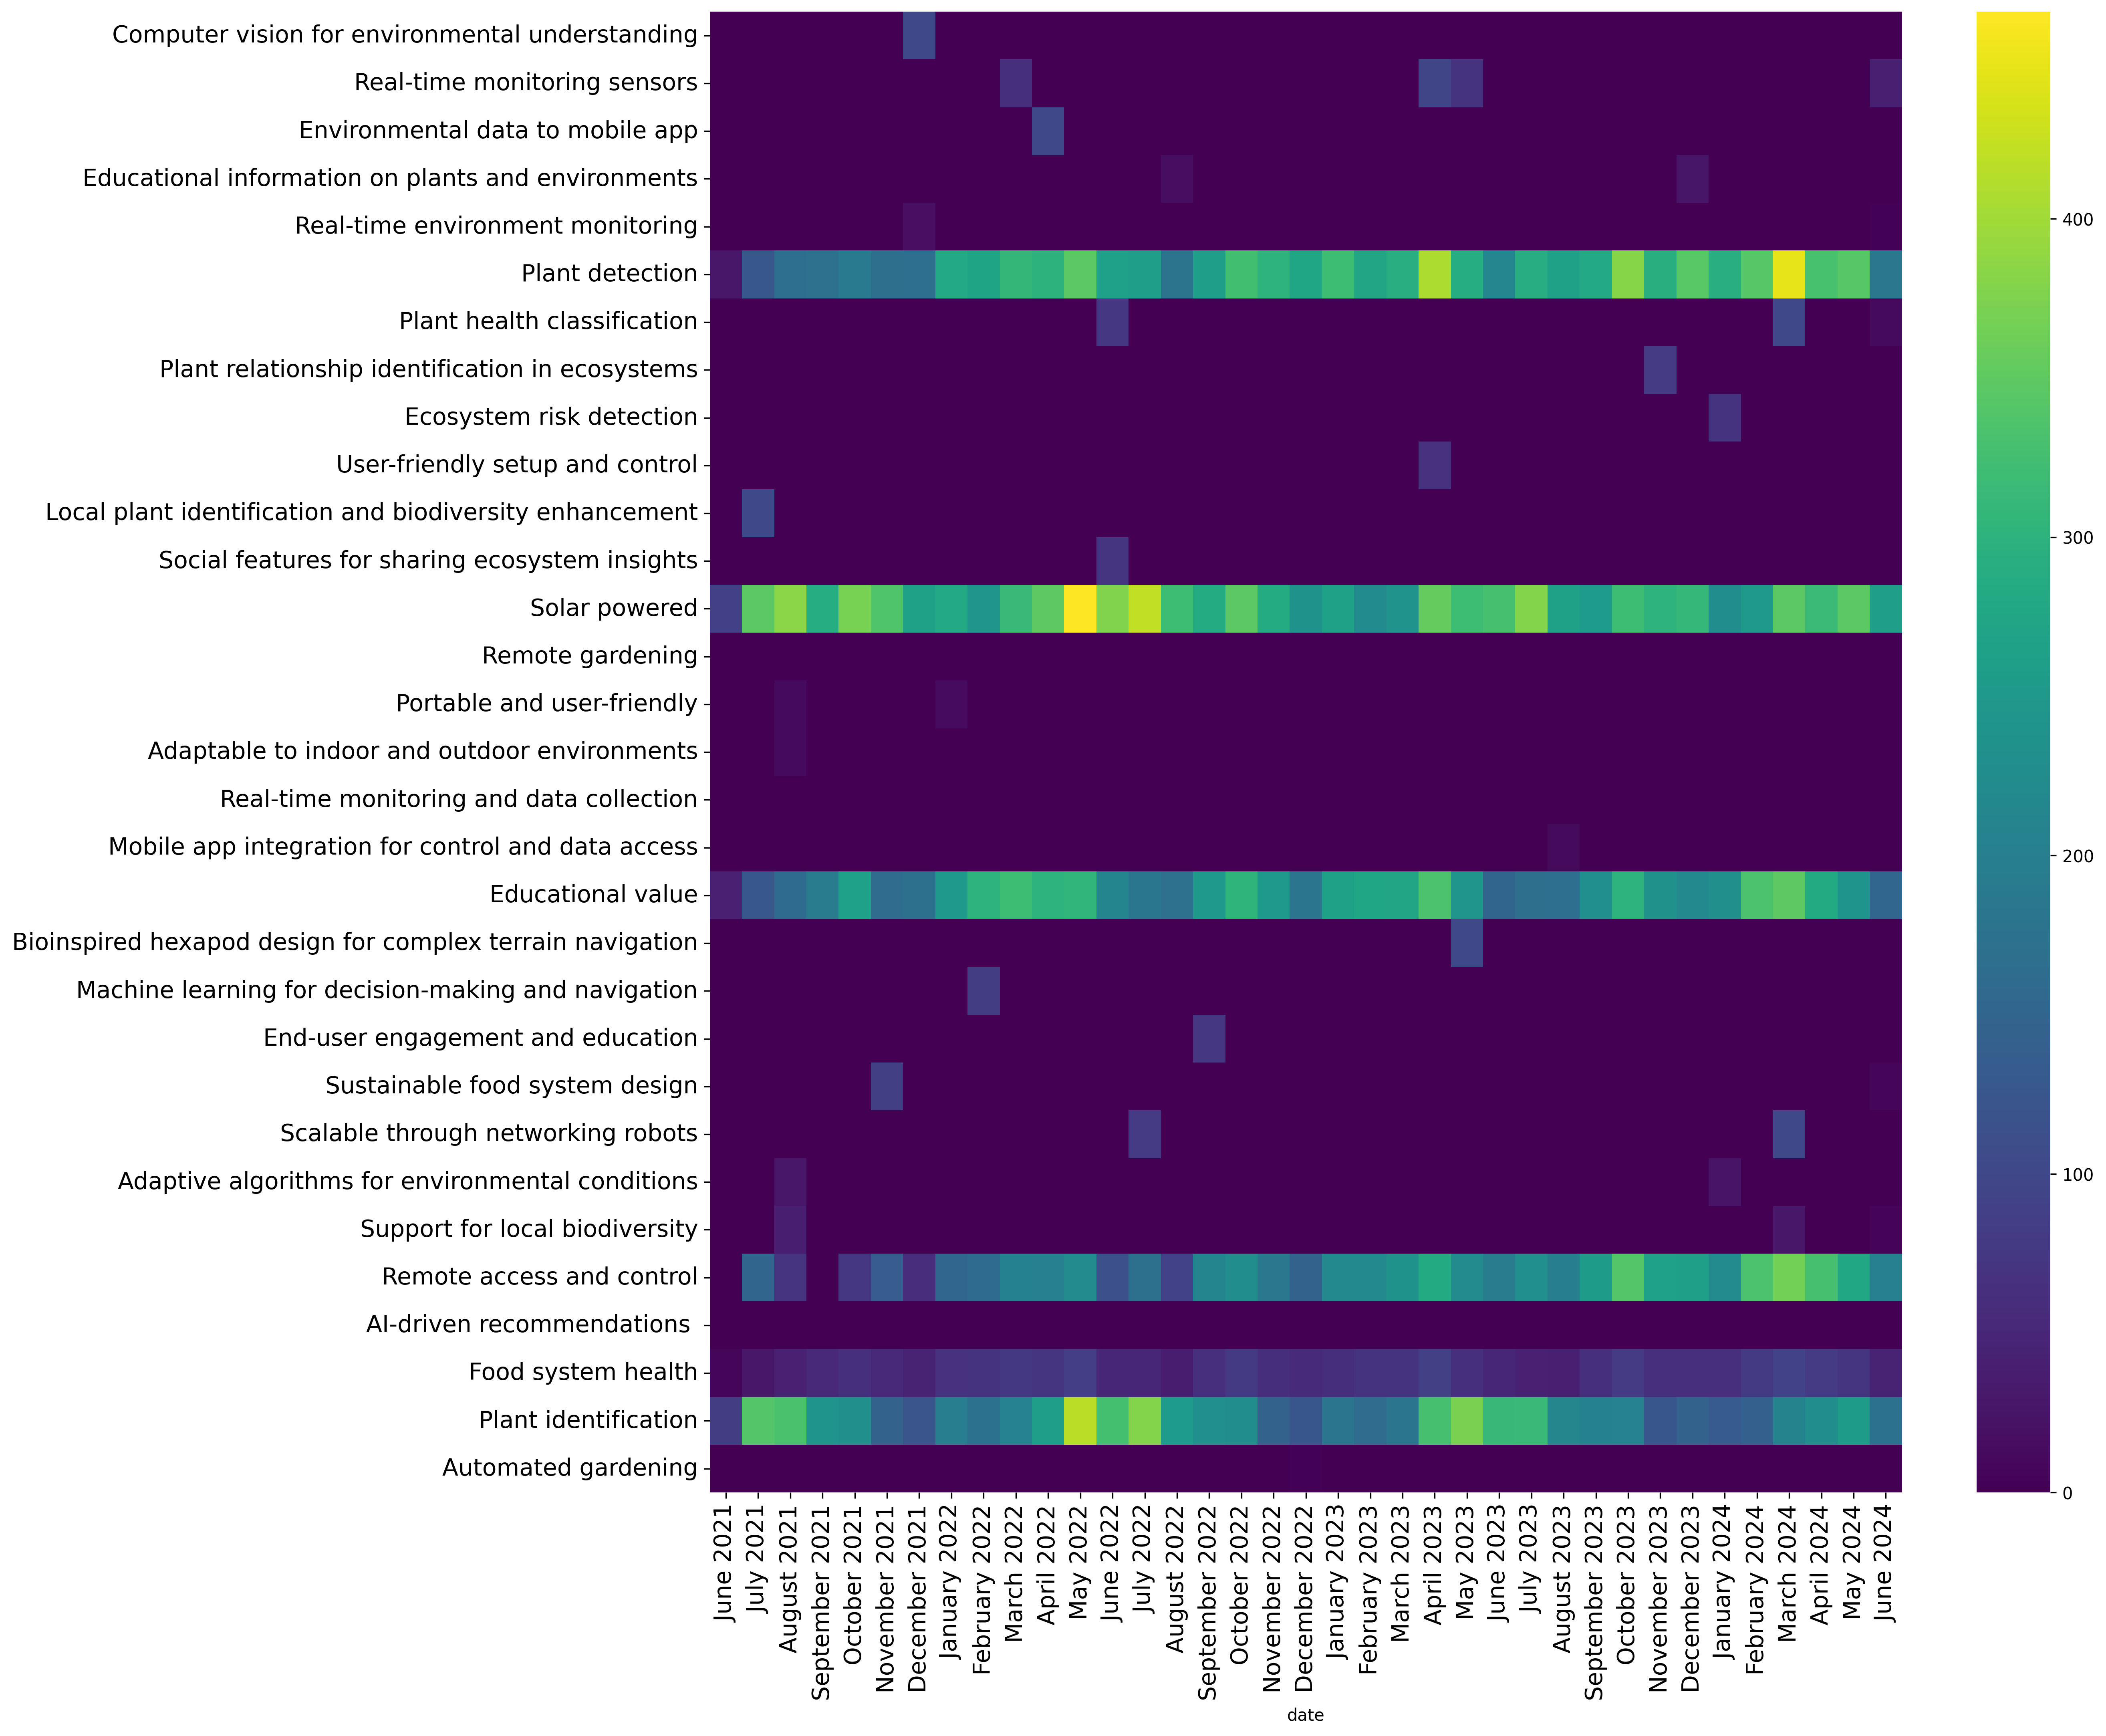

In [36]:
# Create a heatmap to understand how interest changed over time
plt.figure(figsize=(16, 16), dpi=300)
sns.heatmap(data=features_interest_over_time_monthly.T, cmap='viridis', annot=False, cbar=True);
plt.yticks(fontsize=14)
plt.xticks(fontsize=14);

### Visualize most relevant features

In [38]:
# Flatten the dataframe
features_by_interest_flat = features_by_interest.reset_index()
features_by_interest_flat.head()

,index,interest,weekly_average_interest
0,Solar powered,11298,72.229
1,Plant detection,9967,63.719
2,Educational value,8586,54.891
3,Plant identification,8313,53.145
4,Remote access and control,7219,46.151


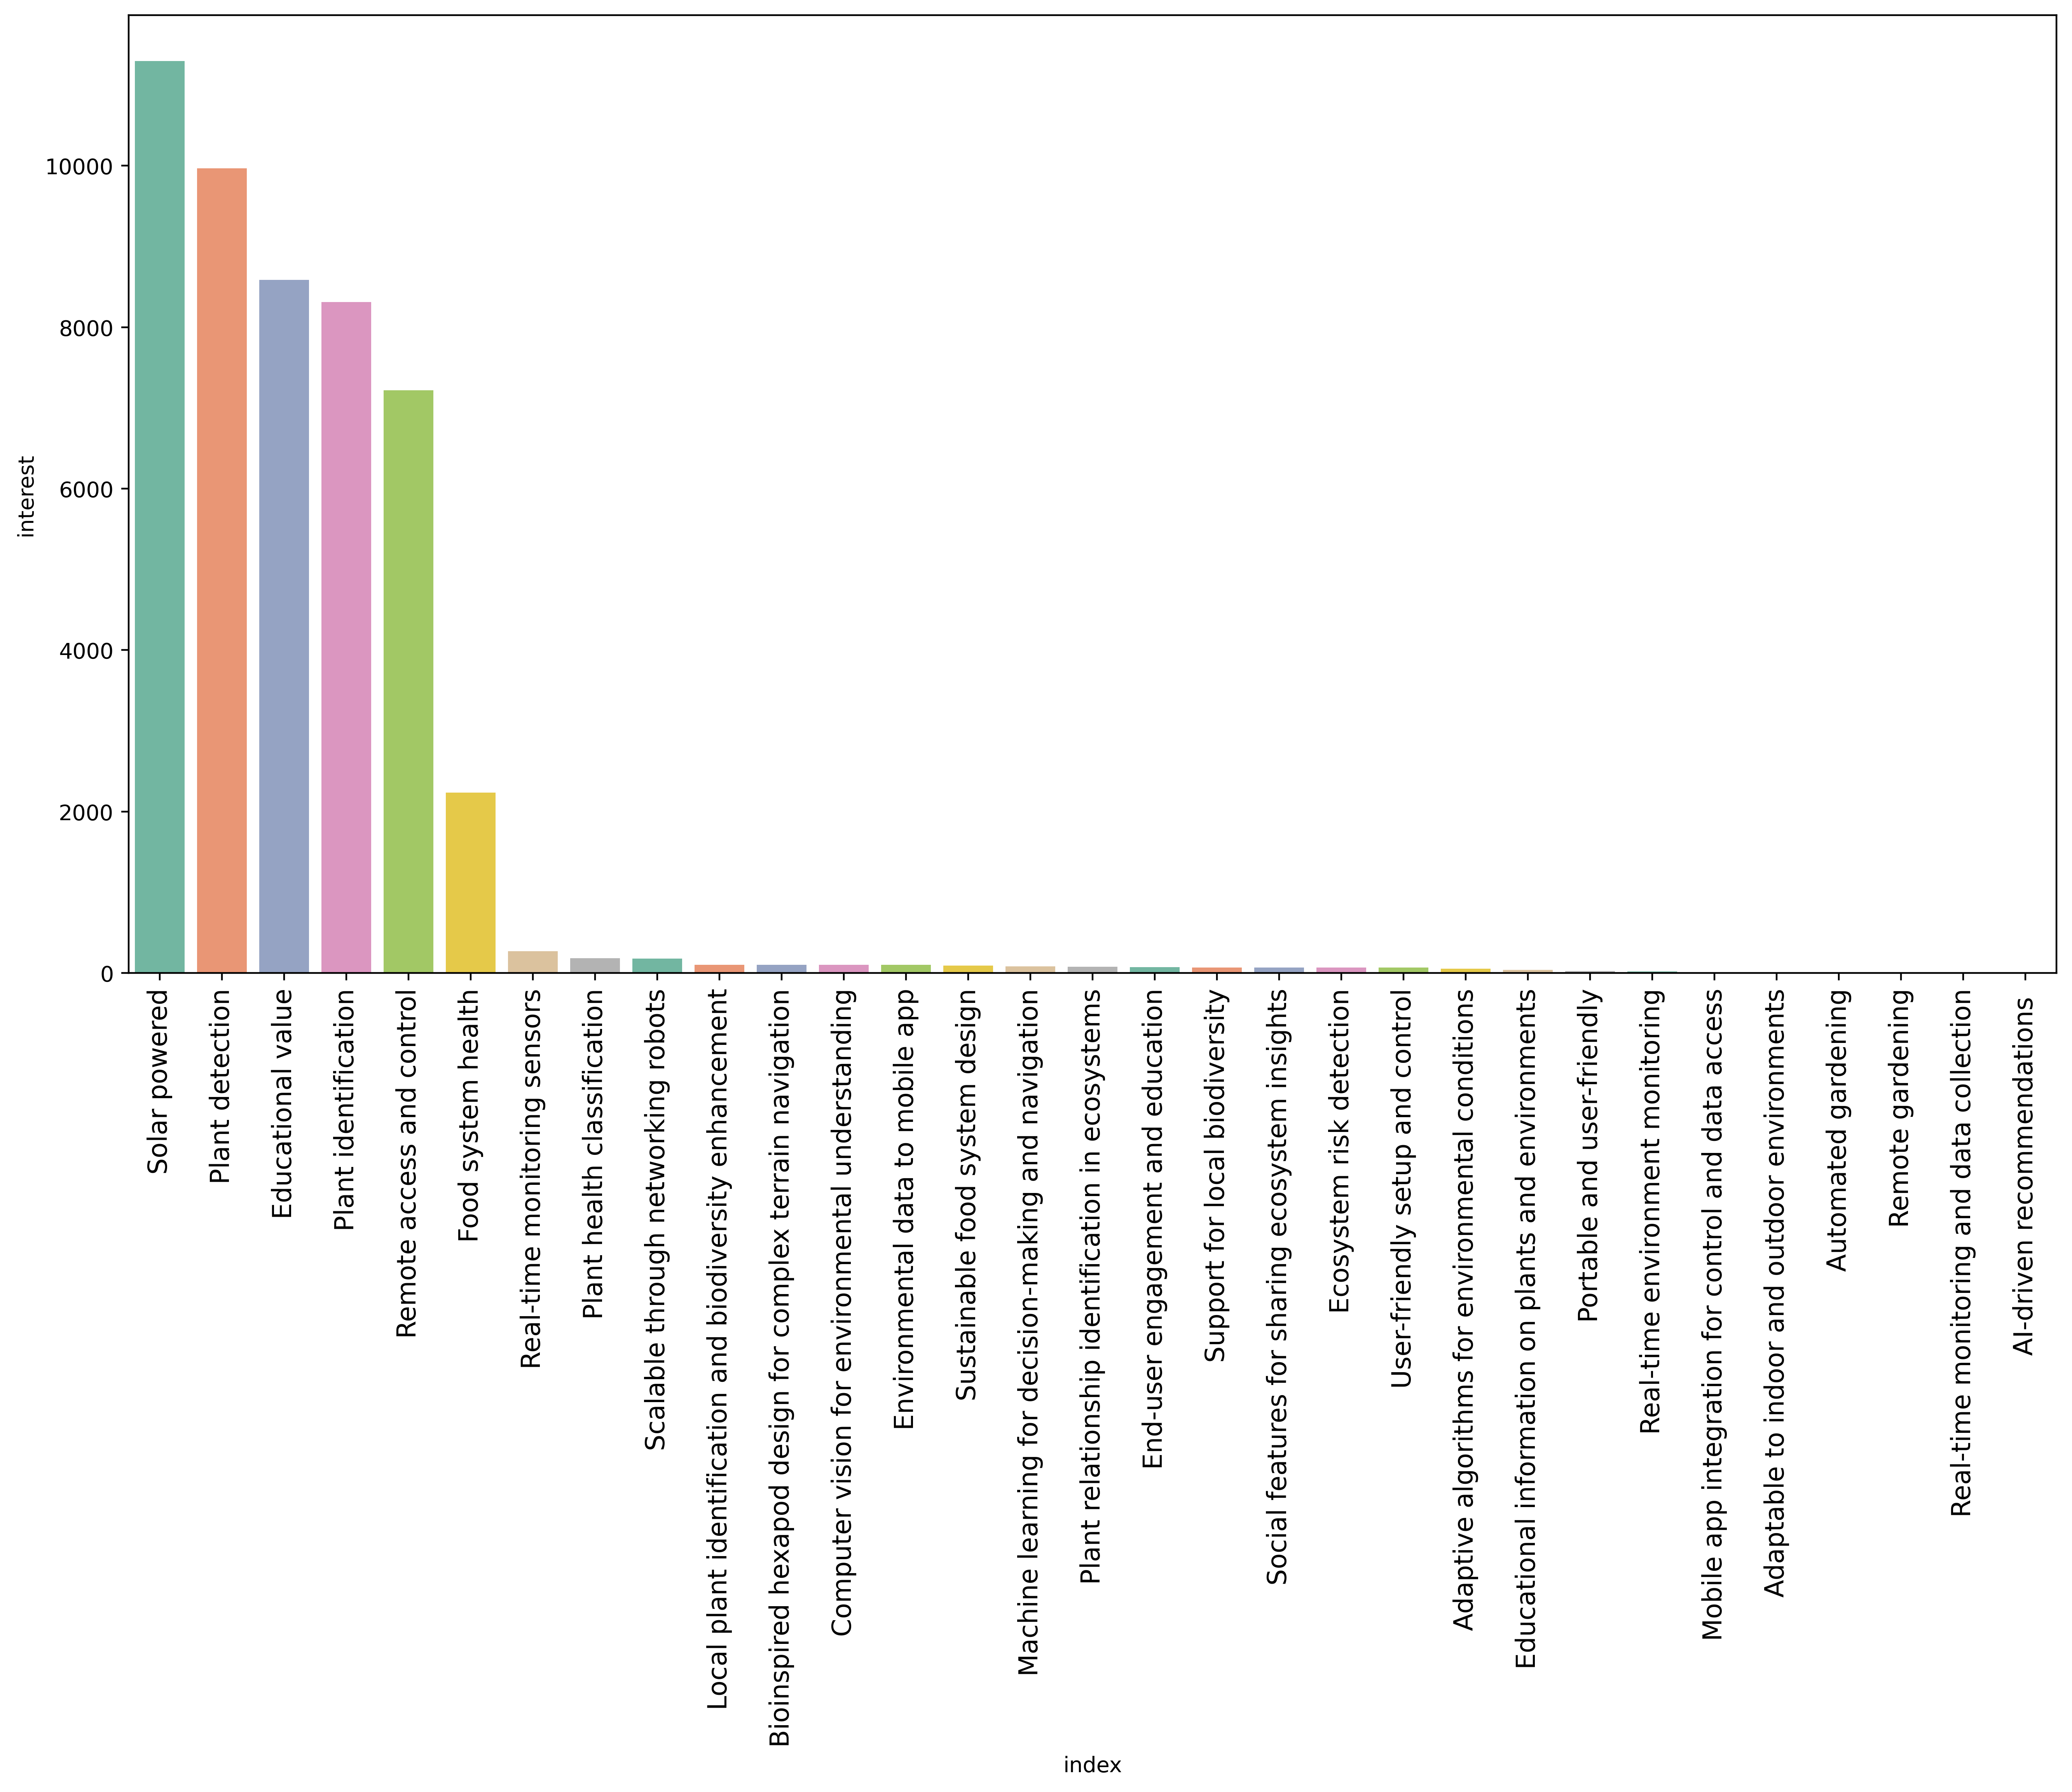

In [39]:
# Visualize overall interest in proposed features
plt.figure(figsize=(16, 8), dpi=400)
sns.barplot(data=features_by_interest_flat, x='index', y='interest', hue='index', palette='Set2');
plt.xticks(rotation=90, fontsize=12);

In [40]:
features_by_interest['weekly_average_interest'] = round(features_by_interest['interest'] / 156.42, 3)
features_by_interest.head()

,interest,weekly_average_interest
Solar powered,11298,72.229
Plant detection,9967,63.719
Educational value,8586,54.891
Plant identification,8313,53.145
Remote access and control,7219,46.151


<a name='evaluate-and-select-relevant-data'></a>
# Evaluate and Select Relevant Data
* Evaluate the explored data and decide which parts are valuable for further analysis



## Evaluate relevant data on interest in features
* Zero interest features need to be further evaluated
* Features by weekly interest are valuable as they are summed up in easy to understand metrics (0 - 100) and provide valuable insights in which prototype features are most relevant and exclude features keywords without results

<a name='store-data-in-gcs'></a>
# Store Data in GCS
* Store cleaned and transformed data in Google Cloud Storage
* Save data in a suitable format
* Upload the data to a designated GCS storage bucket

In [66]:
# Define a function to upload dataframes as parquet to GCS
def upload_dataframe_to_gcs(dataframe, subdirectory, blob_name, project_id=project_id):
    """
    Saves a DataFrame as a Parquet file and uploads it to a specified GCS bucket and subdirectory.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame to be saved and uploaded.
    bucket_name (str): The name of the GCS bucket.
    subdirectory (str): The subdirectory within the GCS bucket where the file will be stored.
    blob_name (str): The name of the blob (file) in GCS.
    project_id (str): The Google Cloud project ID.

    Returns:
    None
    """
    # Save the DataFrame as a Parquet file locally in the /content directory
    temp_path = f'/content/{blob_name}'
    dataframe.to_parquet(temp_path)

    # Verify the file was saved locally
    !ls -lh {temp_path}

    # Upload the Parquet file to GCS in the specified subdirectory
    blob = bucket.blob(f'{subdirectory}/{blob_name}')
    blob.upload_from_filename(temp_path)

    print(f"File {subdirectory}/{blob_name} uploaded to {bucket_name}.")


## Store data on interest on features

### Store features by average weekly interest

In [ ]:
# Define subdirectory for all Google Trends data
subdirectory = 'google_trends'

In [67]:
# Upload the dataframe as parquet to GCS
upload_dataframe_to_gcs(dataframe=features_by_interest, subdirectory=subdirectory, blob_name='features_by_interest.parquet')

-rw-r--r-- 1 root root 4.3K Jun 28 15:04 /content/features_by_interest.parquet
File google_trends/features_by_interest.parquet uploaded to startup-viability-analysis.


### Store features with no interest

In [68]:
zero_interest_features.head()

,zero_interest_keywords
0,Affordable for end users
1,Raspberry Pi processing for community engagement
2,Hexapod mobility and agility
3,AI-driven recommendations for food system health
4,Portable agricultural technology


In [69]:
# Upload the dataframe as parquet to GCS
upload_dataframe_to_gcs(dataframe=zero_interest_features, subdirectory=subdirectory, blob_name='features_zero_interest.parquet')

-rw-r--r-- 1 root root 2.7K Jun 28 15:07 /content/features_zero_interest.parquet
File google_trends/features_zero_interest.parquet uploaded to startup-viability-analysis.
